In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import model_function
import math

In [121]:
exponential_count =2
parameter_count = exponential_count*2+1

Load a model or creat a new one?

In [122]:
load = False
model_path ='models/2024-01-08_14-17-45_3exp_params_517_points_50/model.keras'

In [123]:
df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')
# df = pd.read_csv('measurements/E_4_20ms_20231103_14_55_46.csv', sep=', ')
df.head()

C:\Users\cierpind\AppData\Local\Temp\ipykernel_8628\431649043.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')


,Ch1(mA),Ch2(mA),Ch3(mA),Ch4(mA),Ch5(mA),Ch6(mA),Ch7(mA),Ch8(mA),Ch9(mA),Ch10(mA),...,Ch14(mA),Ch15(mA),Ch16(mA),Channel state,On time,Off time,Pulse number,Pattern,Time,Probeflag
0,0,0,0,0.03421,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,1,1/1000,0.087664,False
1,0,0,0,0.04888,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,2,1/1000,0.182584,False
2,0,0,0,0.06354,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,3,1/1000,0.283189,False
3,0,0,0,0.08309,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,4,1/1000,0.376060,False
4,0,0,0,0.09775,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,5,1/1000,0.469858,False


In [124]:
df = df[ ['Pattern','Time','Ch4(mA)','On time', 'Off time']]
df = df.rename(columns={'Ch4(mA)': 'Current'})
df = df.drop(df.index[:50*10])
df.head()

,Pattern,Time,Current,On time,Off time
500,11/1000,79.005742,1.564,74,155
501,11/1000,79.230081,1.422,74,155
502,11/1000,79.460954,1.329,74,155
503,11/1000,79.690012,1.261,74,155
504,11/1000,79.921769,1.212,74,155


In [125]:
target_points = 50
cutoff_current_min = 0.5
must_be_growth = False
must_be_decay = False
min_gradient =0
max_final_gradient = 1

Text(0.5, 1.0, 'Data to be modeled')

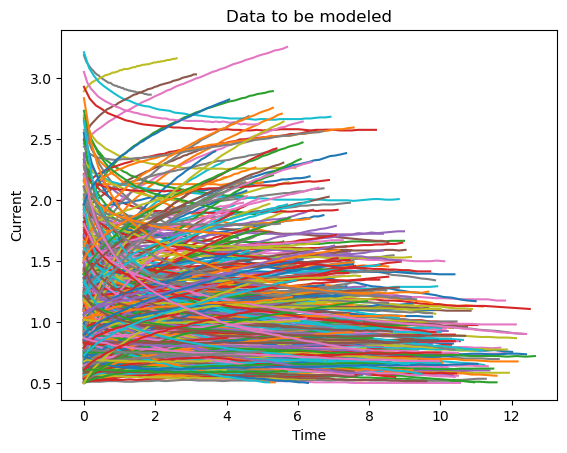

In [126]:
grouped = df.groupby('Pattern')
list_of_dfs = [group for _, group in grouped]
list_of_dfs_fixed = []
for data in list_of_dfs:    
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    points = len(y_current)    
    #(data.loc[0,'Off time'])
    if len(y_current) != target_points:
        print(points)
        continue
    assert x_time.shape == y_current.shape
    assert points == target_points
    if np.min(y_current)>cutoff_current_min and np.max(np.abs(np.gradient(y_current,y_current.index)))>min_gradient and np.min(np.abs(np.gradient(y_current,y_current.index)[:-10]))<max_final_gradient:
        if must_be_growth:
            if y_current.iloc[0]<y_current.iloc[-1]:
                plt.plot(x_time, y_current, '-')
                list_of_dfs_fixed.append(data)
        elif   must_be_decay:
            if y_current.iloc[0]>y_current.iloc[-1]:
                plt.plot(x_time, y_current, '-')
                list_of_dfs_fixed.append(data)          
        else:
            plt.plot(x_time, y_current, '-')
            list_of_dfs_fixed.append(data)
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Data to be modeled')

In [127]:
#initialize array of expected shape
X_data = np.zeros((len(list_of_dfs_fixed),3))
#initialize array of expected shape
y_data = np.zeros((len(list_of_dfs_fixed), points, 2))
prev_on_time = 0
prev_off_time = 0
for i in range(len(list_of_dfs_fixed)):
    data = list_of_dfs_fixed[i]
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    
    if len(y_current) != target_points:
        print(points)
        continue
    if np.max(y_current)>cutoff_current_min:
        label = np.column_stack((x_time,y_current))  
        y_data[i,:,:]= label
        features =  np.array([y_current.iloc[0], data['On time'].iloc[0], data['Off time'].iloc[0]])
        X_data[i,:] = features
    prev_on_time = data['On time'].iloc[0]
    prev_off_time = data['Off time'].iloc[0]

print(f"X shape:{X_data.shape}")
print(f"y shape:{y_data.shape}")


X shape:(498, 3)
y shape:(498, 50, 2)


Y-train can be considered as dependant on pulses only, not on time:

In [128]:
y_data = y_data[:,:,1]
y_data.shape

(498, 50)

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, train_size=0.5)


In [130]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# y_train = scaler.fit_transform(y_train)
# y_val = scaler.transform(y_val)
# y_test = scaler.transform(y_test)



In [131]:
print("Information about x_train values:")
print("Minimum value:", np.min(X_train))
print("Maximum value:", np.max(X_train))
print("Mean value:", np.mean(X_train))
print("Standard deviation:", np.std(X_train))

Information about x_train values:
Minimum value: 0.5034
Maximum value: 159.0
Mean value: 48.22954798850574
Standard deviation: 42.589459514489576


In [132]:
import keras

import tensorflow.keras.backend as K


 

def create_nn(dropout_rate=0.7):
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    x = inputs
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    dropout_layer = True
    params_per_layer = 512
    number_of_layers = 8
    for i in range(number_of_layers):    
        x = keras.layers.Dense(params_per_layer, 'relu')(x)
        if dropout_layer:
            x = keras.layers.Dropout(rate=dropout_rate)(x)

    
    
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    output = keras.layers.Dense(y_train.shape[1], activation = 'relu')(x)
    # Expand parameters to have same shape as y_true
    # expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=output, name="current_function_prediction")

In [133]:
if load:
    model = keras.models.load_model(model_path)
else:
    model = create_nn(dropout_rate=0.1)

model.summary()

Model: "current_function_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_36 (Dense)            (None, 512)               2048      
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 dropout_33 (Dropout)        (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dropout_34 (Dropout)        (None, 512

In [134]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer='adam', #'sgd'
                  loss='msle'
                  )
    


number_of_epochs = 300




earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss",baseline = 1, patience=number_of_epochs,restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                              factor=0.8, 
                              patience=20, 
                              min_lr=1e-8)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    if y_lim != 0:
        plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [144]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=number_of_epochs,
                    validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                               ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/300
3/3 - 0s - loss: 0.0062 - val_loss: 0.0070 - lr: 5.1200e-04 - 116ms/epoch - 39ms/step
Epoch 2/300
3/3 - 0s - loss: 0.0053 - val_loss: 0.0065 - lr: 5.1200e-04 - 88ms/epoch - 29ms/step
Epoch 3/300
3/3 - 0s - loss: 0.0061 - val_loss: 0.0085 - lr: 5.1200e-04 - 102ms/epoch - 34ms/step
Epoch 4/300
3/3 - 0s - loss: 0.0060 - val_loss: 0.0083 - lr: 5.1200e-04 - 97ms/epoch - 32ms/step
Epoch 5/300
3/3 - 0s - loss: 0.0055 - val_loss: 0.0083 - lr: 5.1200e-04 - 81ms/epoch - 27ms/step
Epoch 6/300
3/3 - 0s - loss: 0.0055 - val_loss: 0.0084 - lr: 5.1200e-04 - 82ms/epoch - 27ms/step
Epoch 7/300
3/3 - 0s - loss: 0.0058 - val_loss: 0.0062 - lr: 5.1200e-04 - 107ms/epoch - 36ms/step
Epoch 8/300
3/3 - 0s - loss: 0.0056 - val_loss: 0.0104 - lr: 5.1200e-04 - 96ms/epoch - 32ms/step
Epoch 9/300
3/3 - 0s - loss: 0.0062 - val_loss: 0.0072 - lr: 5.1200e-04 - 109ms/epoch - 36ms/step
Epoch 10/300
3/3 - 0s - loss: 0.0060 - val_loss: 0.0075 - lr: 5.1200e-04 - 77ms/epoch - 26ms/step
Epoch 11/300
3/3 - 0s - l

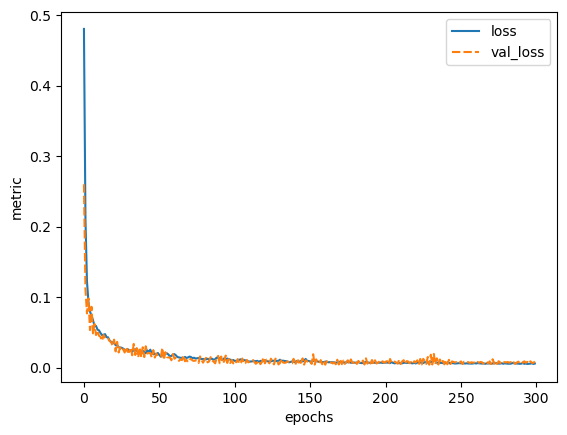

In [143]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss', 'val_loss'], 0)

In [137]:
# # Save the model
# import os
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# # model.save('models/'+filename)


# folder_path = f'models/{current_date}_{exponential_count}exp_params_{model.count_params()}_points_{points}'
# os.makedirs(folder_path, exist_ok=True)
# model.save(folder_path+'/model.keras')
# model.save(folder_path+'/model.h5')

In [138]:
# make prediction on test data
y_train_prediction = model.predict(X_train)

11/11 [==============================] - 0s 3ms/step


3/3 [==============================] - 0s 0s/step


Text(0.5, 1.0, 'Absolute Error of test data prediction')

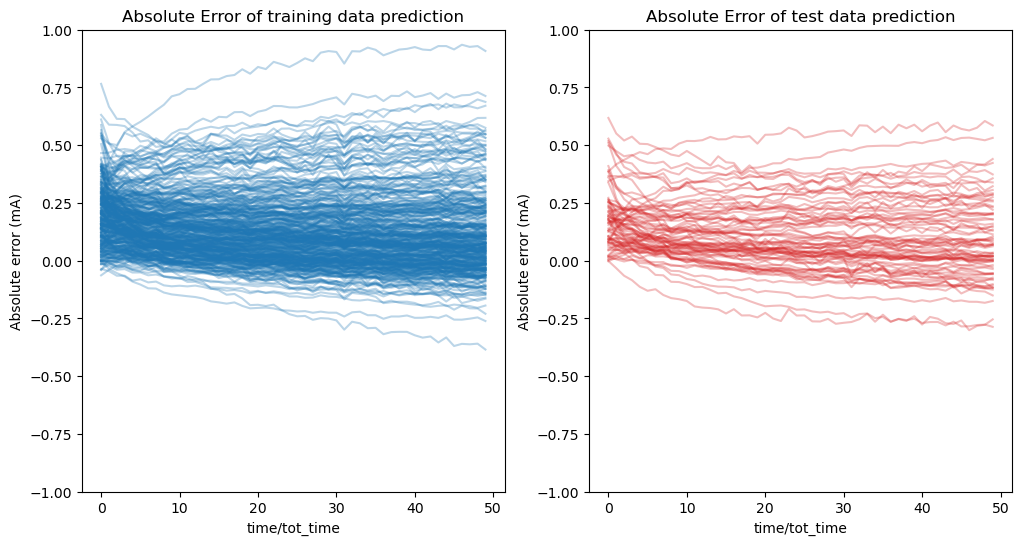

In [139]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
for test_entry_index in range(y_train_prediction.shape[0]):
    # c = next(color)
    y_true = y_train[test_entry_index,:]
    y_predicted = y_train_prediction[test_entry_index,:  ]
    plt.plot(y_true- y_predicted, '-', color = 'C0', alpha = 0.3, )
# plt.legend()
    plt.ylim(-1,1)
plt.xlabel('time/tot_time')
plt.ylabel('Absolute error (mA)')
plt.title('Absolute Error of training data prediction')


y_test_prediction = model.predict(X_test)


plt.subplot(1, 2, 2)
for test_entry_index in range(X_test.shape[0]):    
    y_true = y_test[test_entry_index,:]
    y_predicted = y_test_prediction[test_entry_index,:]
    plt.plot( y_true-y_predicted, '-', color = 'C3', alpha = 0.3, )
    
#plt.legend()
plt.ylim(-1,1)
plt.xlabel('time/tot_time')
plt.ylabel('Absolute error (mA)')
plt.title('Absolute Error of test data prediction')
# plt.savefig(f"{folder_path}/performance.png")

Relative error plots

3/3 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'Relative Error of test data prediction')

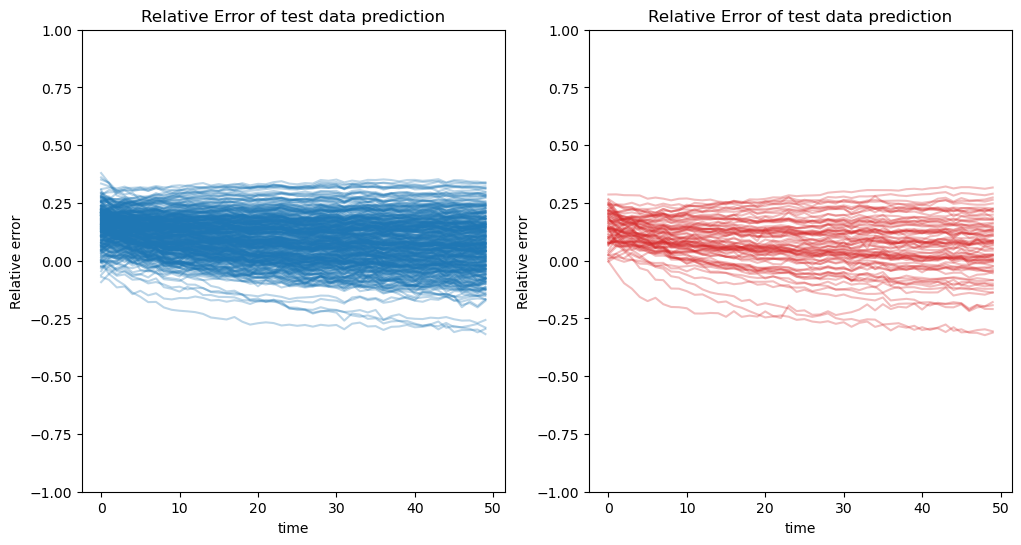

In [140]:
plt.figure(figsize=(12, 6))

y_train_prediction = model.predict(X_train)

plt.subplot(1, 2, 1)
for test_entry_index in range(X_train.shape[0]):
    y_true = y_train[test_entry_index,:]
    y_predicted = y_train_prediction[test_entry_index,:]
    plt.plot((y_true- y_predicted)/y_true, '-', color = 'C0', alpha = 0.3, )

    plt.ylim(-1,1)
plt.xlabel('time')
plt.ylabel('Relative error')
plt.title('Relative Error of test data prediction')


y_test_prediction = model.predict(X_test)

plt.subplot(1, 2, 2)
for test_entry_index in range(X_test.shape[0]):
    y_true = y_test[test_entry_index,:]
    y_predicted = y_test_prediction[test_entry_index,: ]
    plt.plot((y_true- y_predicted)/y_true, '-', color = 'C3', alpha = 0.3, )
    plt.ylim(-1,1)    
plt.xlabel('time')
plt.ylabel('Relative error')
plt.title('Relative Error of test data prediction')

Plot bad predictions

3/3 [==============================] - 0s 5ms/step
32 75


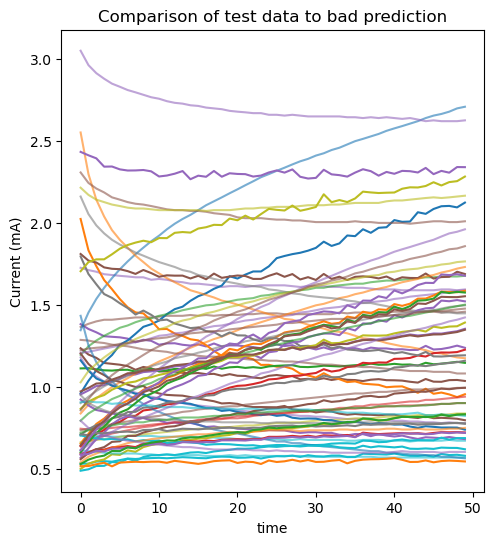

In [141]:
plt.figure(figsize=(12, 6))
y_test_prediction = model.predict(X_test)
plt.subplot(1, 2, 2)
count_total = X_test.shape[0]
count_bad = 0
for test_entry_index in range(X_test.shape[0]):
    y_true = y_test[test_entry_index,:]
    y_predicted = y_test_prediction[test_entry_index,: ]
    if np.max(np.abs((y_true- y_predicted)/y_true))>0.2:
        plt.plot(y_predicted, '-', color = f'C{test_entry_index}', alpha = 1, )
        plt.plot(y_true, '-', color = f'C{test_entry_index}', alpha = 0.6, )
        count_bad +=1
          
plt.xlabel('time')
plt.ylabel('Current (mA)')
plt.title('Comparison of test data to bad prediction')
print(count_bad, count_total)

plot good predictions

3/3 [==============================] - 0s 2ms/step
6
16
20
34
40
68
69
70
72
9 75


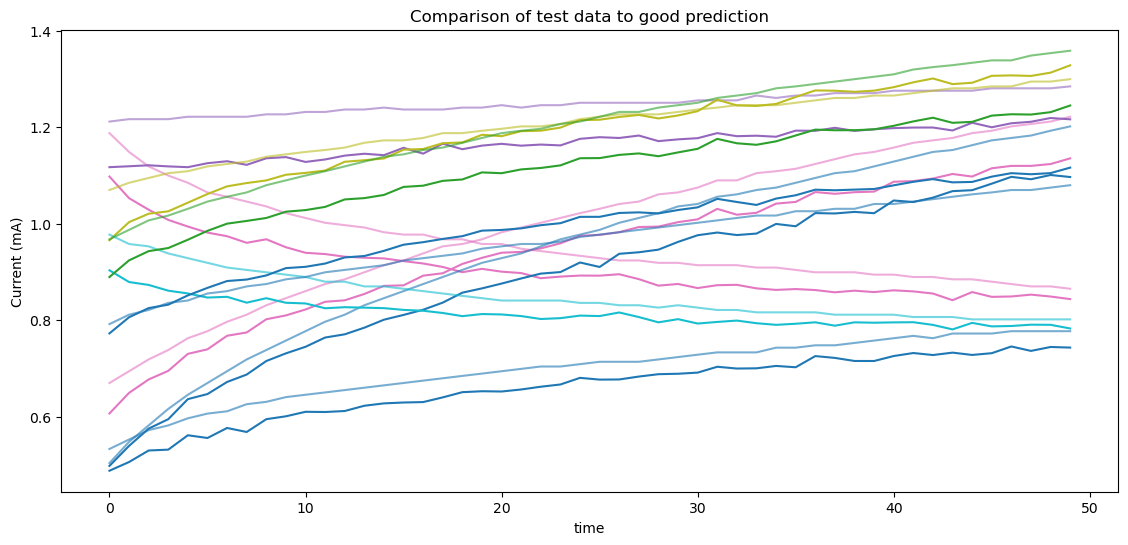

In [142]:
plt.figure(figsize=(30, 6))
y_test_prediction = model.predict(X_test)
plt.subplot(1, 2, 2)
count_total = X_test.shape[0]
count_good = 0
for test_entry_index in range(X_test.shape[0]):
    y_true = y_test[test_entry_index,:]
    y_predicted = y_test_prediction[test_entry_index,: ]
    if np.max(np.abs((y_true- y_predicted)/y_true))<0.1:
        print(test_entry_index)
        plt.plot(y_predicted, '-', color = f'C{test_entry_index}', alpha = 1, )
        plt.plot(y_true, '-', color = f'C{test_entry_index}', alpha = 0.6, )
        count_good +=1
          
plt.xlabel('time')
plt.ylabel('Current (mA)')
plt.title('Comparison of test data to good prediction')
print(count_good, count_total)